In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 1️⃣ Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# 2️⃣ Load dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and std for MNIST
])

dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform)

# Split train into train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

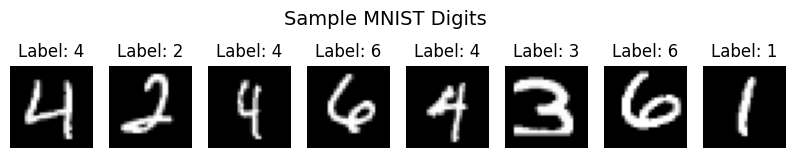

In [4]:
# 2️⃣.5️⃣ Visualize some MNIST digits
import matplotlib.pyplot as plt

# Get a small batch of images
examples = iter(train_loader)
images, labels = next(examples)

# Plot first 8 digits
plt.figure(figsize=(10, 2))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Sample MNIST Digits", fontsize=14)
plt.show()


In [5]:
# 3️⃣ Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

model = CNN().to(device)
model

CNN(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [6]:
# 4️⃣ Loss & optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
# 5️⃣ Training loop with validation
epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = outputs.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # --- Validation ---
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)

            val_running_loss += loss.item() * X.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    # --- Save metrics ---
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

Epoch 1/10: Train Loss=0.1819, Train Acc=0.9446, Val Loss=0.0781, Val Acc=0.9760
Epoch 2/10: Train Loss=0.0542, Train Acc=0.9836, Val Loss=0.0611, Val Acc=0.9818
Epoch 3/10: Train Loss=0.0362, Train Acc=0.9888, Val Loss=0.0517, Val Acc=0.9837
Epoch 4/10: Train Loss=0.0273, Train Acc=0.9916, Val Loss=0.0539, Val Acc=0.9852
Epoch 5/10: Train Loss=0.0192, Train Acc=0.9935, Val Loss=0.0553, Val Acc=0.9838
Epoch 6/10: Train Loss=0.0151, Train Acc=0.9947, Val Loss=0.0597, Val Acc=0.9841
Epoch 7/10: Train Loss=0.0148, Train Acc=0.9949, Val Loss=0.0595, Val Acc=0.9842
Epoch 8/10: Train Loss=0.0115, Train Acc=0.9959, Val Loss=0.0560, Val Acc=0.9862
Epoch 9/10: Train Loss=0.0086, Train Acc=0.9969, Val Loss=0.0601, Val Acc=0.9847
Epoch 10/10: Train Loss=0.0072, Train Acc=0.9977, Val Loss=0.0622, Val Acc=0.9851


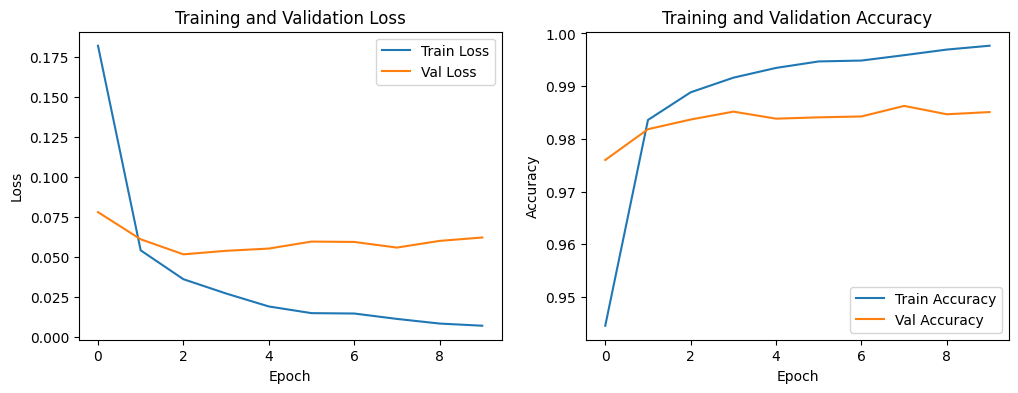

In [8]:
# 6️⃣ Plot metrics
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.show()